In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'random/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
features = ['megno']

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

# Fraction not chaotic over 1e4 orbits

In [7]:
(testX['megno']<2.5).sum()/testX['megno'].shape[0]

0.4754

# Fraction not chaotic over 1e4 orbits that were stable

In [8]:
regular = testX['megno'] < 2.5
testY[regular].sum()/testY.shape[0]

0.3804

# Fraction chaotic over 1e4 orbits that were stable

In [9]:
chaotic = testX['megno'] > 2.5
testY[chaotic].sum()/testY.shape[0]

0.0124

In [10]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9518711400000001                                  
ERROR                                               
0.0041138845868596                                  
HOLDOUT SCORE                                       
0.961423593243945                                   
SCORE:                                                                         
0.95132106                                                                     
ERROR                                                                          
0.004119895898830517                                                           
HOLDOUT SCORE                                                                  
0.9592331752523735                                                             
SCORE:                                                                         
0.95327026                                                                     
ERROR                                     

ERROR                                                                          
0.003874254431222133                                                           
HOLDOUT SCORE                                                                  
0.9616035518534649                                                             
SCORE:                                                                         
0.9539133999999999                                                             
ERROR                                                                          
0.0037141686139906386                                                          
HOLDOUT SCORE                                                                  
0.9620410489944855                                                             
SCORE:                                                                         
0.9528138599999998                                                             
ERROR                                   

In [12]:
best

{'x_learning_rate': 0.13462893070879323,
 'x_max_depth': 5,
 'x_min_child': 7.0,
 'x_pos_weight': 1.7882251914936251,
 'x_subsample': 0.8618715501643678,
 'x_tree_colsample': 0.8109018115662547}

In [13]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.955186+0.000902587	test-auc:0.952986+0.00431592
[1]	train-auc:0.955887+0.000913554	test-auc:0.953134+0.00414382
[2]	train-auc:0.956423+0.000825621	test-auc:0.953599+0.00409808
[3]	train-auc:0.956753+0.000737714	test-auc:0.953942+0.00414473
[4]	train-auc:0.957095+0.000781053	test-auc:0.954224+0.00406495
[5]	train-auc:0.957583+0.000943951	test-auc:0.954712+0.00378776
[6]	train-auc:0.957836+0.000731885	test-auc:0.954729+0.00394691
[7]	train-auc:0.958098+0.000874411	test-auc:0.954975+0.00386426
[8]	train-auc:0.958126+0.000859872	test-auc:0.95498+0.00384626
[9]	train-auc:0.958266+0.00090571	test-auc:0.954941+0.00391385
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.955186       0.000903       0.952986      0.004316
1        0.955887       0.000914       0.953134      0.004144
2        0.956423       0.000826       0.953599      0.004098
3        0.956753       0.000738       0.953942      0.004145
4        0.957095       0.000781       0.954224     

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [14]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8109018115662547, gamma=0,
              learning_rate=0.13462893070879323, max_delta_step=0, max_depth=5,
              min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.7882251914936251,
              seed=None, silent=True, subsample=0.8618715501643678)

Text(0.5, 1.0, 'ROC curve (AUC = 0.962)')

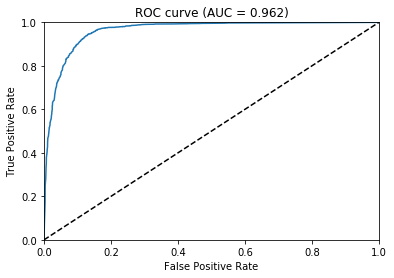

In [15]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [16]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.006097455509006977, recall = 1.0, precision = 0.3938
Threshold 0.02513366937637329, recall = 0.9949212798374809, precision = 0.5881116781747223
Threshold 0.031938277184963226, recall = 0.9933976637887253, precision = 0.6193793540215327
Threshold 0.039417002350091934, recall = 0.9928897917724734, precision = 0.6462809917355372
Threshold 0.058503974229097366, recall = 0.9923819197562215, precision = 0.6616999661361328
Threshold 0.08436315506696701, recall = 0.9908583037074657, precision = 0.6812150837988827
Threshold 0.10027322918176651, recall = 0.9867953275774505, precision = 0.7001801801801801
Threshold 0.11562831699848175, recall = 0.983748095479939, precision = 0.7144964957580229
Threshold 0.13599535822868347, recall = 0.9807008633824277, precision = 0.7297808012093726
Threshold 0.15750257670879364, recall = 0.97866937531742, precision = 0.7411538461538462
Threshold 0.18258869647979736, recall = 0.9771457592686643, precision = 0.7521501172791243
Threshold 0.2176022380590

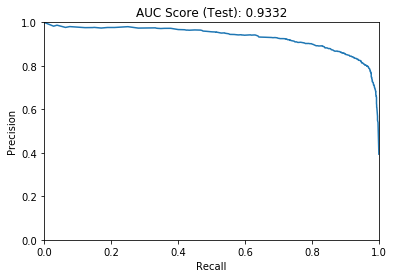

In [17]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 819.5000000000001)

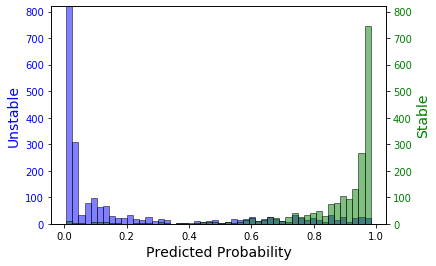

In [19]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

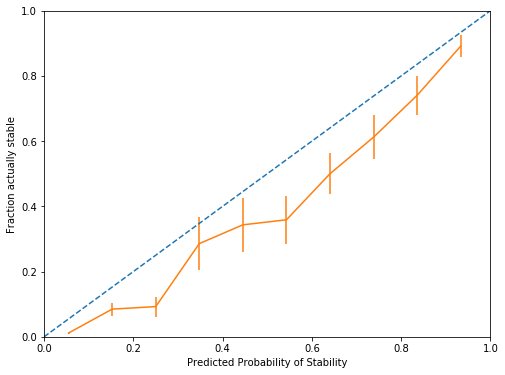

In [20]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

../modelfitting.py:99: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment
../modelfitting.py:99: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment


Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

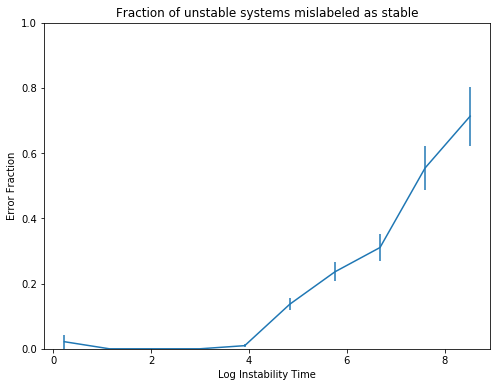

In [21]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

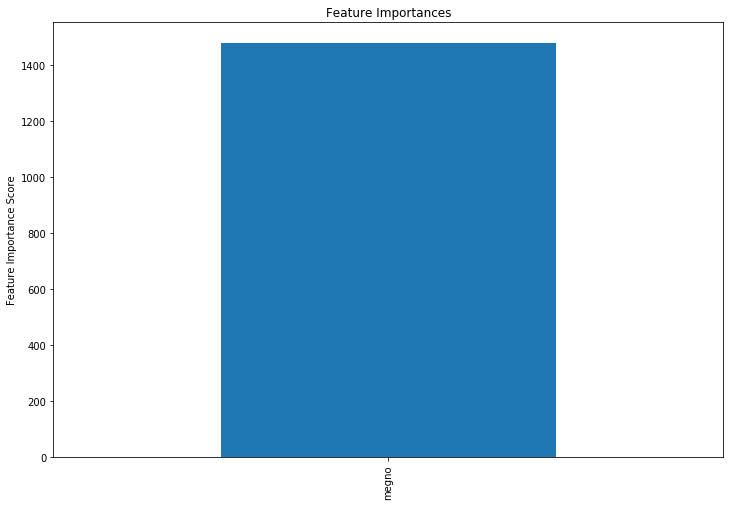

In [22]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [23]:
dill.dump([model, features, featurefolder], open(datapath+"../models/megnoxgb_random.pkl", "wb"))

# Test how many nonchaotic systems were unstable

In [8]:
model, features, featurefolder = dill.load(open(datapath+"../models/megnoxgb_random.pkl", "rb")) 

In [18]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, labelname='instability_time')

In [19]:
(testY < 1e4).sum()

1507

In [20]:
(testY < 1e4).sum()/testY.shape[0]

0.3014

In [21]:
longterm = testY > 1e4

In [22]:
longterm.sum()

3493

In [35]:
chaotic = (testX['megno'] > 2.5) & longterm
nonchaotic = (~chaotic) & longterm & ~testX['megno'].isnull()

In [36]:
chaotic.sum()

1033

In [37]:
nonchaotic.sum()

2373

In [38]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [39]:
stable = testY
unstable = ~testY

# Out of the nonchaotic systems living > 1e4, 20% were unstable

In [40]:
unstable[nonchaotic].sum()/nonchaotic.sum()

0.19848293299620734

# Out of the chaotic systems living > 1e4, 6% were stable

In [41]:
stable[chaotic].sum()/chaotic.sum()

0.060019361084220714

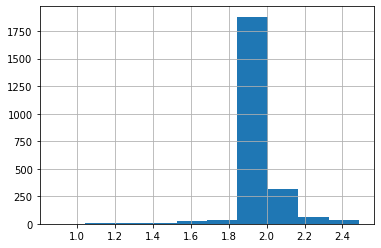

In [16]:
testX[nonchaotic]['megno'].hist()